In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ete3

import os
from tqdm import tqdm
import pickle

from src.phylogenetic_signal import PagelsLambda
from src.ihmp import get_diffs
from src.greengenes import (
    parse_similarity_map, merge_otu_table, combine_similarity_maps
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%%bash

# Download greengenes OTUs dataset, if necessary
if ! [ -d greengenes/data/gg_13_5_otus/ ]; then
    if ! [ -f greengenes/data/gg_13_5_otus.tar.gz ]; then
        wget -O greengenes/data/gg_13_5_otus.tar.gz \
            https://gg-sg-web.s3-us-west-2.amazonaws.com/downloads/greengenes_database/gg_13_5/gg_13_5_otus.tar.gz
    fi
    tar -xvf greengenes/data/gg_13_5_otus.tar.gz -C greengenes/data/
fi

In [5]:
# I load OTU tables using the basic iHMP scripts from earlier notebooks

data = {
    name: get_diffs(name, get_abundances=True, log=False)  # undo log transform
    for name in ["ibd", "moms", "t2d"]
}


In [6]:
# Sanity check 1: relative abundances continue to sum to 1
# They do!!!
similarity_map99 = parse_similarity_map(99)
similarity_map = similarity_map99
for x in [97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:
    similarity_map = combine_similarity_maps(
        [similarity_map, parse_similarity_map(x)]
    )
    clustered = merge_otu_table(data["ibd"], similarity_map)
    s = clustered.sum(axis=1)
    print(f"{x} {clustered.shape} {s.min():.3f} {s.mean():.3f} {s.max():.3f}")


/home/phil/phylosig/src/greengenes.py:207: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_otu_table[cluster_id] = otu_table[existing_otus].sum(axis=1)


97 (98, 1370) 1.000 1.000 1.000
94 (98, 1171) 1.000 1.000 1.000
91 (98, 799) 1.000 1.000 1.000
88 (98, 536) 1.000 1.000 1.000
85 (98, 337) 1.000 1.000 1.000
82 (98, 203) 1.000 1.000 1.000
79 (98, 118) 1.000 1.000 1.000
76 (98, 82) 1.000 1.000 1.000
73 (98, 43) 1.000 1.000 1.000
70 (98, 24) 1.000 1.000 1.000
67 (98, 13) 1.000 1.000 1.000
64 (98, 8) 1.000 1.000 1.000
61 (98, 6) 1.000 1.000 1.000


In [7]:
# Get lambdas for each cutoff

# for name in names:
#     outpath = f"./results/{name}_{ab_str}pls_top{TOP_N}.tsv"
#     print(outpath)
#     if os.path.exists(outpath):
#         print(f"Skipping {outpath} because it already exists.")
#         continue
#     pls, tree = pagels_dataframe(data[name], GG_TREE)
#     pls.to_csv(outpath, sep="\t")
#     tree.write(
#         format=1, outfile=f"./results/{name}_{ab_str}tree_top{TOP_N}.nwk"
#     )

for name in ["ibd", "moms", "t2d"]:
    lambdas = []

    similarity_map99 = parse_similarity_map(99)
    similarity_map = similarity_map99
    for x in [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:

        # Non-redundancy check
        outpath = f"./results/{name}_pls_cutoff{x}.tsv"
        if os.path.exists(outpath):
            print(f"Skipping {outpath} because it already exists.")
            lambdas_cutoff_df = pd.read_csv(outpath, sep="\t")
            lambdas_cutoff_df["cutoff"] = x
            lambdas_cutoff_df["dataset"] = name
            lambdas.append(lambdas_cutoff_df)
            continue

        lambdas_cutoff = []

        # Get GreenGenes data
        if x == 99:  # Special case
            similarity_map = similarity_map99
        else:
            similarity_map = combine_similarity_maps(
                [similarity_map, parse_similarity_map(x)]
            )
        tree = ete3.Tree(
            f"./greengenes/data/gg_13_5_otus/trees/{x}_otus.tree",
            format=1,
            quoted_node_names=True,
        )

        # Filter OTU table
        clustered = merge_otu_table(data[name], similarity_map)
        s = clustered.sum(axis=1)
        print(
            f"{x} {clustered.shape} {s.min():.3f} {s.mean():.3f} {s.max():.3f}"
        )

        # Filter tree, init PL object
        if os.path.exists(f"./results/{name}_pl_cutoff{x}.pkl"):
            pl = pickle.load(f"./results/{name}_pl_cutoff{x}.pkl")
        else:
            tree.prune(clustered.columns)
            pl = PagelsLambda(tree, memoized=True)
            pickle.dump(pl, f"./results/{name}_pl_cutoff{x}.pkl")
        print(f"Tree has {len(pl.tree)} leaves.")

        # Get lambdas
        for sample in tqdm(clustered.index):
            pl.fit(clustered.loc[sample])
            lambdas_cutoff.append({"sample": sample, "lambda": pl.lam})

        lambdas_cutoff_df = pd.DataFrame(lambdas_cutoff)
        lambdas_cutoff_df.to_csv(outpath, sep="\t")

        lambdas_cutoff_df["cutoff"] = x
        lambdas_cutoff_df["dataset"] = name
        lambdas.append(lambdas_cutoff_df)

lambdas_df = pd.concat(lambdas)


Skipping ./results/ibd_pls_cutoff99.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff97.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff94.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff91.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff88.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff85.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff82.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff79.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff76.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff73.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff70.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff67.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff64.tsv because it already exists.
Skipping ./results/ibd_pls_cutoff61.tsv because it already exists.
99 (9170, 7665) 1.000 1.000 1.000


In [ ]:
lambdas_df


,Unnamed: 0,sample,lambda,cutoff
0,0,"('feces', 3001, 4, 'CSM5FZ3N')",1.0,99
1,1,"('feces', 3002, 5, 'CSM5FZ3X')",1.0,99
2,2,"('feces', 3002, 6, 'CSM5FZ3Z')",1.0,99
3,3,"('feces', 3002, 8, 'CSM5FZ44')",1.0,99
4,4,"('feces', 3002, 9, 'CSM5FZ46')",1.0,99
...,...,...,...,...
93,93,"('feces', 2021, 11, 'MSM5LLIO')",1.0,61
94,94,"('feces', 2026, 4, 'MSM5LLIQ')",1.0,61
95,95,"('feces', 2027, 4, 'MSM5LLIS')",1.0,61
96,96,"('feces', 2014, 9, 'MSM5ZOJY')",1.0,61


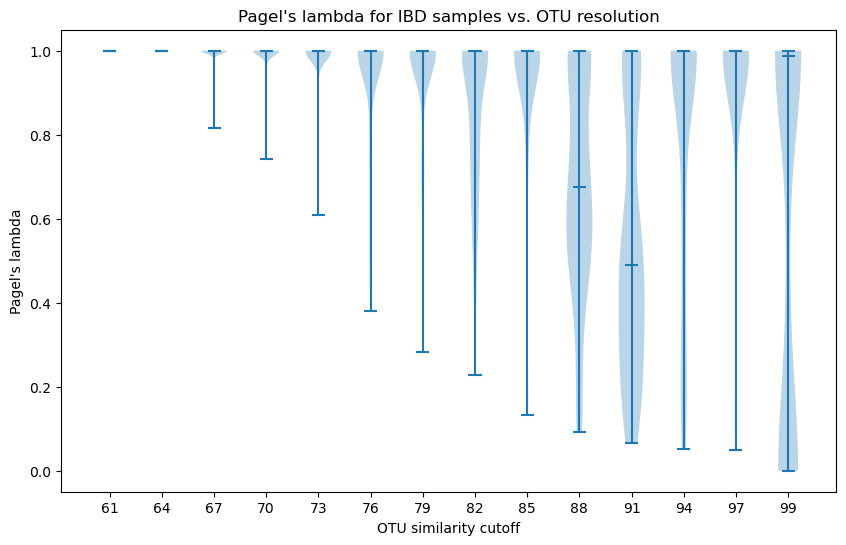

In [ ]:
import seaborn as sns

#  = pd.DataFrame(columns=["sample", "lambda", "cutoff"])
# for x in [99, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]:
#     result = pd.read_table(f"./results/ibd_pls_cutoff{x}.tsv")
#     result["cutoff"] = x
#     cluster_lambda = cluster_lambda.append(result)

# Violin plot for each cutoff
fig, ax = plt.subplots(figsize=(10, 6))

# for lam in lambdas_df.groupby("cutoff"):
#     lam = lam[1]
# sns.violinplot(
#     x="cutoff", y="lambda", data=lambdas_df, ax=ax, inner="quartile", cut=0
# )

lams_to_plot = lambdas_df.groupby("cutoff")["lambda"].apply(list)

plt.violinplot(lams_to_plot, showmedians=True)
plt.xticks(range(1, len(lams_to_plot) + 1), lams_to_plot.index)
plt.xlabel("OTU similarity cutoff")
plt.ylabel("Pagel's lambda")
plt.title("Pagel's lambda for IBD samples vs. OTU resolution")
plt.show()
